In [24]:
import matplotlib.pyplot as plt
import numpy as np # convert pictures to Arrays
import pandas as pd
import seaborn as sns
import zipfile
import os
import sys
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from PIL import Image # To read pictures

warnings.filterwarnings('ignore')
#global declaration
FILE_NAME = '\youTubeVideoData_680473'
sns.set()

In [25]:
absolutepath = os.path.dirname(os.path.abspath("__file__"))
print(absolutepath)

fileDirectory = os.path.dirname(absolutepath)
print(fileDirectory)#Path of parent directory
parentDirectory = os.path.dirname(fileDirectory)
print(parentDirectory)
#Navigate to Strings directory
newPath = os.path.join(parentDirectory, 'data', 'raw')   
print(newPath)

C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\eda
C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook
C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT
C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\data\raw


In [26]:
# unzipping the datafile from data raw folder to 
with zipfile.ZipFile(newPath+FILE_NAME+'.zip',"r") as zip_ref:
    zip_ref.extractall(absolutepath)

In [27]:
absolutepath+FILE_NAME

'C:\\Users\\vgarg\\Documents\\GitHub\\Recommendation-System-for-YT\\notebook\\eda\\youTubeVideoData_680473'

In [28]:
df = pd.read_csv(absolutepath+FILE_NAME+'.csv', index_col=0, low_memory=False)

In [29]:
for column in df.columns:
    if (column.find('Count')>0): 
        df[column].replace('[]','0', inplace = True)
        df[column].replace('','0', inplace = True)
        df = df.astype({column:int})
    else:
        df[column] = df[column].convert_dtypes()

In [30]:
df.shape

(680473, 12)

In [31]:
df.columns.values

array(['ContentId', 'title', 'viewCount', 'likeCount', 'dislikeCount',
       'commentCount', 'favoriteCount', 'publishedAt', 'description',
       'topicCategories', 'duration', 'tags'], dtype=object)

In [32]:
df = df.drop('topicCategories', axis = 1)

In [33]:
df.dtypes

ContentId        string
title            string
viewCount         int32
likeCount         int32
dislikeCount      int32
commentCount      int32
favoriteCount     int32
publishedAt      string
description      string
duration         string
tags             string
dtype: object

In [34]:
(df['favoriteCount'] == 0). sum()

680473

In [35]:
df.drop('favoriteCount',axis =1, inplace = True)

In [36]:
#missing value check
df.isnull().sum().sum()

9708

In [37]:
# df_plot = df.drop(['title'])
count_col = []
for column in df.columns:
    if (column.find('Count')<0):
        count_col.append(column)
df_eda = df.drop(count_col, axis = 1)
df_eda.columns.values
df_eda

,viewCount,likeCount,dislikeCount,commentCount
0,10814444,298544,11821,36687
1,1432519,48398,972,3475
2,20686975,297683,15042,22395
3,531332,21739,654,1592
4,386427,17893,274,407
...,...,...,...,...
149522,4655,125,4,27
150399,15018,439,12,58
150416,8493,261,14,11
161424,25228,1510,23,110


In [38]:
df.head()

,ContentId,title,viewCount,likeCount,dislikeCount,commentCount,publishedAt,description,duration,tags
0,uzl8Fooi_LE,"Jodaa (Official Video) Jatinder Shah, Afsana K...",10814444,298544,11821,36687,2021-10-11T05:30:09Z,Universal Music proudly brings to you legendar...,PT4M52S,"['vyrl originals', 'vyrl original', 'jodaa', '..."
1,w8yoR0IMs08,"Jodaa (Official Teaser) Jatinder Shah, Afsana ...",1432519,48398,972,3475,2021-10-09T05:30:03Z,Universal Music brings to you the teaser of th...,PT29S,"['vyrl originals', 'vyrl original', 'jodaa', '..."
2,JngV9Ix5hnk,"Majnu (Official Video) Sukriti, Prakriti, Mell...",20686975,297683,15042,22395,2021-09-30T05:30:13Z,After all the love you have given their hit si...,PT3M30S,"['vyrl originals', 'vyrl original', 'sukriti',..."
3,8AOZLArpvOA,"Majnu (Official Teaser) Sukriti, Prakriti, Mel...",531332,21739,654,1592,2021-09-28T05:32:03Z,This one's for all the Majnu's in the house! 😉...,PT29S,"['sukriti', 'sukriti kakar', 'prakriti', 'prak..."
4,C7mF13gjjd0,Vishal Mishra - Aaj Bhi (WORMONO LoFi Remake) ...,386427,17893,274,407,2021-09-27T05:30:09Z,VYRL Originals presents WORMONO LoFi Remake of...,PT3M37S,"['vyrl originals', 'Aaj Bhi', 'vishal mishra',..."


In [39]:
df_eda = df_eda.loc[~df.index.duplicated(), :]

In [40]:
df_eda

,viewCount,likeCount,dislikeCount,commentCount
0,10814444,298544,11821,36687
1,1432519,48398,972,3475
2,20686975,297683,15042,22395
3,531332,21739,654,1592
4,386427,17893,274,407
...,...,...,...,...
55723,1952,7,0,0
55925,4735,85,2,4
55940,571,1,0,1
56332,3635,27,2,2


In [41]:
df_eda.describe()
    

,viewCount,likeCount,dislikeCount,commentCount
count,4.628490e+05,4.628490e+05,462849.000000,4.628490e+05
mean,5.298768e+05,9.397322e+03,437.643726,4.562833e+02
std,5.944080e+06,8.126736e+04,5203.641355,8.177980e+03
min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,1.943000e+03,1.900000e+01,2.000000,1.000000e+00
50%,1.565300e+04,2.020000e+02,13.000000,1.100000e+01
75%,1.317480e+05,1.756000e+03,89.000000,7.500000e+01
max,1.168627e+09,1.798469e+07,874071.000000,3.172471e+06


<Figure size 2160x2160 with 0 Axes>

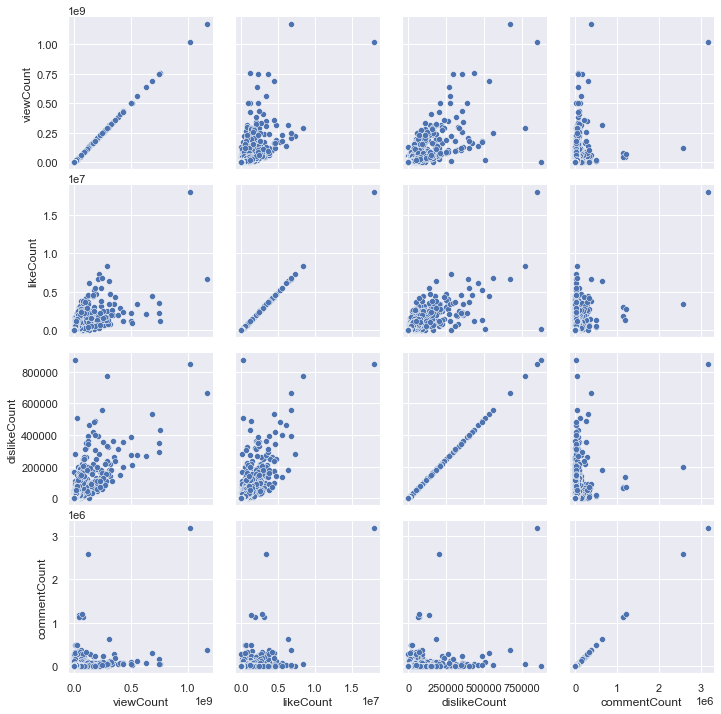

In [19]:
plt.figure(figsize=(30,30)) 
g=sns.PairGrid(df_eda)
g.map(sns.scatterplot)

<AxesSubplot:>

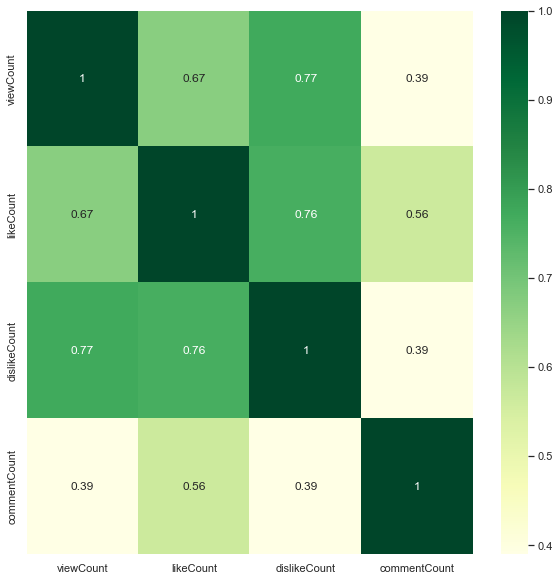

In [20]:
plt.figure(figsize=(10,10)) 
sns.heatmap(df_eda.corr(), annot=True,cmap = 'YlGn')

In [64]:
def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("","",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    return text

def get_stop_words(stop_file_path):
    """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)
    
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=5):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

def tfidf(filename, image):
    df = pd.read_csv(filename,index_col=[0])
    print("Data Read")
    df['title'] = df['title'].convert_dtypes()
    df['description'] = df['description'].convert_dtypes()
    df = df.dropna()
    df = df.reset_index(drop=True)
    print("Null values dropped")
    df['text'] = df['title'] + df['description']

#     df = df[:10] ## TO BE DELETE, just for POC coding

    df['text'] = df['text'].apply(lambda x:pre_process(x))

    #load a set of stop words
    stopwords=get_stop_words(r"C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\Preprocessing\resources\stopwords.txt")

    #get the text column 
    docs=df['text'].tolist()

    #create a vocabulary of words, 
    #ignore words that appear in 85% of documents, 
    #eliminate stop words
    cv=CountVectorizer(max_df=0.85,stop_words=stopwords)
    word_count_vector=cv.fit_transform(docs)
#     print(list(cv.vocabulary_.keys())[:10])
    
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(word_count_vector)
    # you only needs to do this once, this is a mapping of index to 
    feature_names=cv.get_feature_names()
    i = 0
    tex_list = df['text'].tolist()
    tf_idf_vector_list = []
    for i in range(len(tex_list)):
        tf_idf_vector=tfidf_transformer.transform(cv.transform([tex_list[i]]))
        i = i+1
        tf_idf_vector_list.append(tf_idf_vector)
    print("Tf-idf Generated")
    
    sorted_items_list=[]
    i=0
    for i in range(len(tf_idf_vector_list)):
        sorted_items=sort_coo(tf_idf_vector_list[i].tocoo())
        i = i+1
        sorted_items_list.append(sorted_items)
    print("Sorting Complete")
    keyword_list = []
    i=0
    for i in range(len(sorted_items_list)):
        keywords=extract_topn_from_vector(feature_names,sorted_items_list[i],5)
        i = i+1
        keyword_list.append(keywords)
    print("Top 5 extraction done")
    count_list = []
    comment_words=''
    for i  in range(len(keyword_list)):
        for k in keyword_list[i]:
            count_list.append(k)
#             if((i%10000)==0):
#                 print("Keywords added",i)
            comment_words += "".join(k)+" "
    print("Keywords text file create")
    
    mask = np.array(Image.open(image))# Path for Image of the state
    
    wordcloud = WordCloud(width = 2000, height = 1600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 5,
                mask = mask,
                collocations=False).generate(comment_words)
    return wordcloud
#     plot the WordCloud image                      
#     plt.figure(figsize = (8, 8), facecolor = None)
#     plt.imshow(wordcloud)
#     plt.axis("off")
#     plt.tight_layout(pad = 0)

#     plt.imshow(wordcloud, interpolation='bilinear')

In [65]:
## get all state data file name and image file name and store 
def get_state_data(states, zip_files):
    absolutepath = os.path.dirname(os.path.abspath("__file__"))
    print(absolutepath)

    fileDirectory = os.path.dirname(absolutepath)
    print(fileDirectory)#Path of parent directory
    parentDirectory = os.path.dirname(fileDirectory)
    print(parentDirectory)
    #Navigate to Strings directory
    newPath = os.path.join(parentDirectory, 'data', 'raw')   
    print(newPath)
    for zip_file in zip_files:      
        with zipfile.ZipFile(newPath+'\\'+zip_file+'.zip',"r") as zip_ref:
            zip_ref.extractall(absolutepath)
    image_files = []
    data_files = []
    for state in states:
        image_files.append(absolutepath+'\\'+state+'.png')
        data_files.append(absolutepath+'\\'+'youTubeSearchList'+state+'.csv')
    return image_files, data_files  
    

In [66]:
# # Change existing images to high resolution image


# # img_interp.py
# import os
# import sys
# import numpy as np
# from scipy.interpolate import griddata
# import matplotlib.pyplot as plt
# from PIL import Image

# image_files,data_files = get_state_data(states,zip_files)

# def make_interpolated_image(nsamples, image):
#     ix = np.random.randint(im.shape[1], size=nsamples)
#     iy = np.random.randint(im.shape[0], size=nsamples)
#     samples = im[iy,ix]
#     int_im = griddata((iy, ix), samples, (Y, X))
#     return int_im

# for image in image_files:
#     # Read in image and convert to greyscale array object
#     img_name = image
#     im = Image.open(img_name)
#     im = np.array(im.convert('L'))
    
#     # A meshgrid of pixel coordinates
#     nx, ny = im.shape[1], im.shape[0]
#     X, Y = np.meshgrid(np.arange(0, nx, 1), np.arange(0, ny, 1))
    
#     # Create a figure of nrows x ncols subplots, and orient it appropriately
#     # for the aspect ratio of the image.
    
#     plt.figure(figsize = (6,6), facecolor = None)
    
#     # Convert an integer i to coordinates in the ax array
#     get_indices = lambda i: (i // nrows, i % ncols)
    
#     # Sample 100, 1,000, 10,000 and 100,000 points and plot the interpolated
#     # images in the figure
#     nsamples = 1000000
#     # axes = ax[get_indices(i)]
#     plt.imshow(make_interpolated_image(nsamples,image),
#                           cmap=plt.get_cmap('Greys_r'))
#     # plt.set_xticks([])
#     # plt.set_yticks([])
#     # plt.title('nsamples = {0:d}'.format(nsamples))
#     filestem = os.path.splitext(os.path.basename(img_name))[0]
#     plt.savefig(image, dpi=300)
    

In [67]:
# #Quick testing
# ## TO BE DELETED
# wordcloud1 = tfidf(r"C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\eda\youTubeSearchListGujarat.csv",
#       r"C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\eda\Gujarat.png")
# plt.figure(figsize = (6,6), facecolor = None)
# plt.imshow(wordcloud1)
# plt.axis("off")
# plt.tight_layout(pad = 0)
# plt.show()

In [68]:
states = ['Assam','Chattishgarh','Gujarat','Haryana','Karntaka','Kerala','MadyaPradesh',
         'Maharastra','TamilNadu','Telangana','Tripura','UttarPradesh','WestBengal']
zip_files = ['13IndianStateMapImage','13IndianStateYouTubeData']

In [69]:
image_files,data_files = get_state_data(states,zip_files)

C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\eda
C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook
C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT
C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\data\raw


In [70]:
states_wordcloud = []
for image_file, data_file in zip(image_files,data_files):
    print( 'Data File:-', data_file, "\n",'Image File:-', image_file)
    states_wordcloud.append(tfidf(data_file,image_file))
print("Total No of state for world cloud:-",len(states_wordcloud))

Data File:- C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\eda\youTubeSearchListAssam.csv 
 Image File:- C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\eda\Assam.png
Data Read
Null values dropped
Tf-idf Generated
Sorting Complete
Top 5 extraction done
Keywords text file create
Data File:- C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\eda\youTubeSearchListChattishgarh.csv 
 Image File:- C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\eda\Chattishgarh.png
Data Read
Null values dropped
Tf-idf Generated
Sorting Complete
Top 5 extraction done
Keywords text file create
Data File:- C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\eda\youTubeSearchListGujarat.csv 
 Image File:- C:\Users\vgarg\Documents\GitHub\Recommendation-System-for-YT\notebook\eda\Gujarat.png
Data Read
Null values dropped
Tf-idf Generated
Sorting Complete
Top 5 extraction done
Keywords text file create
Data File:

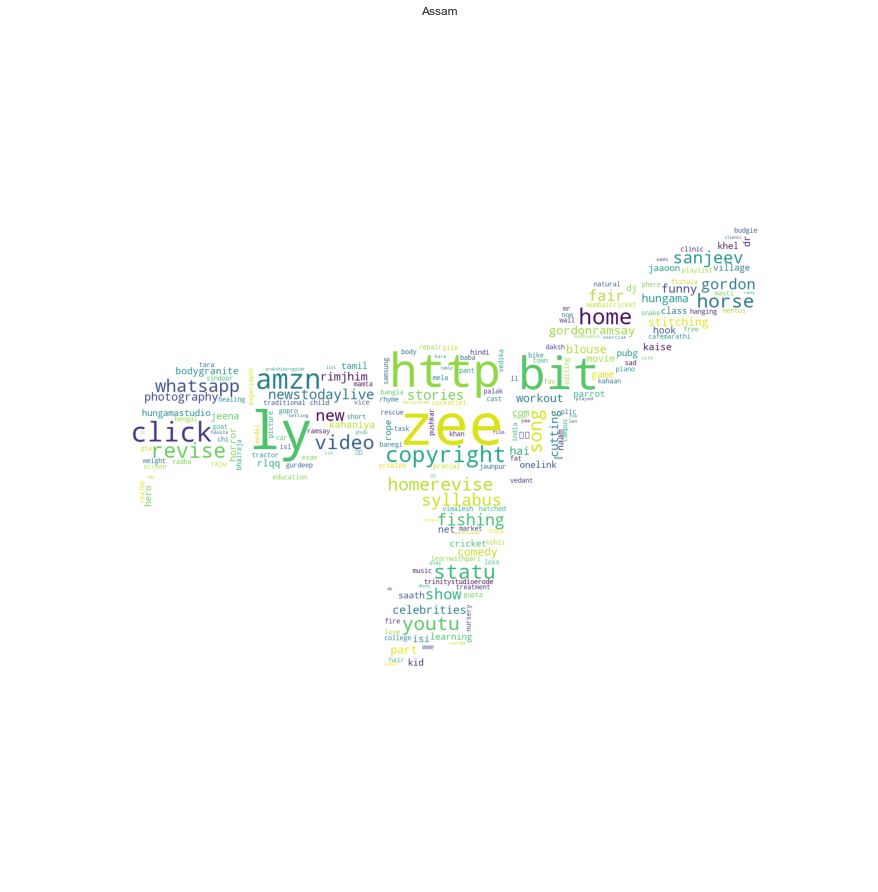

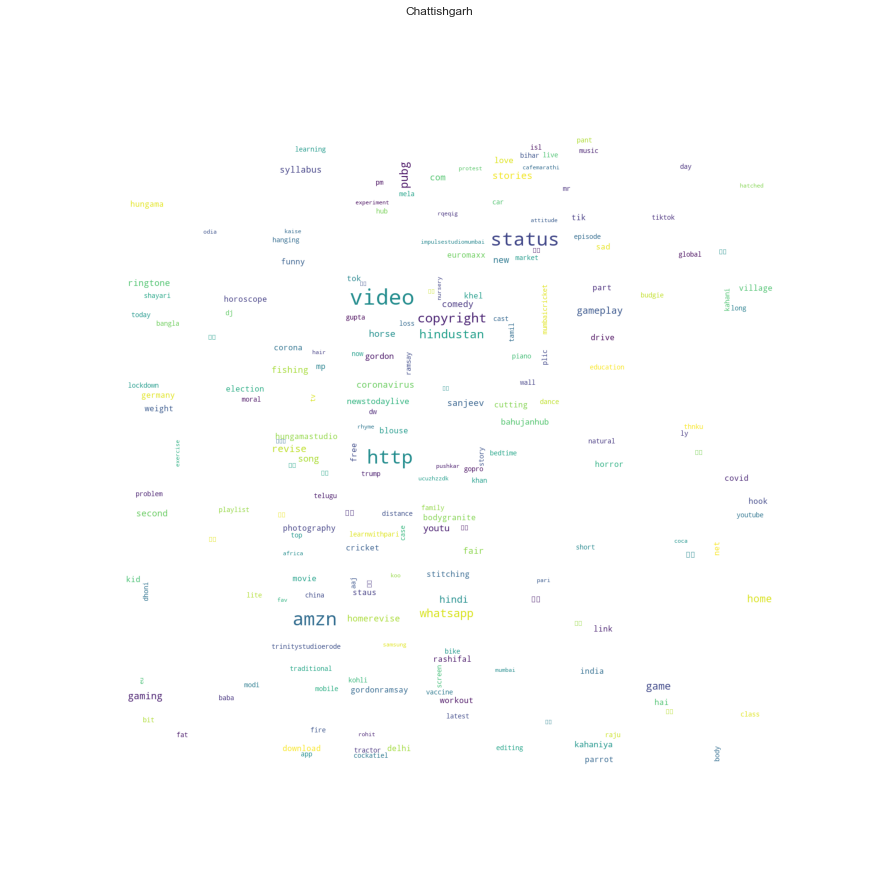

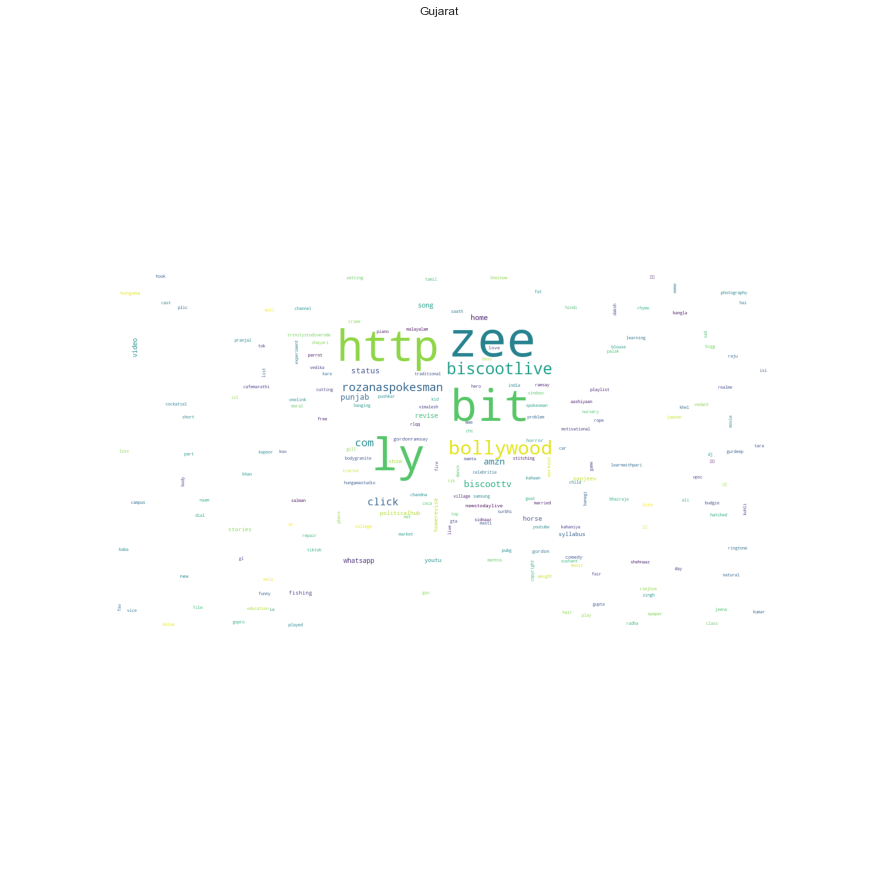

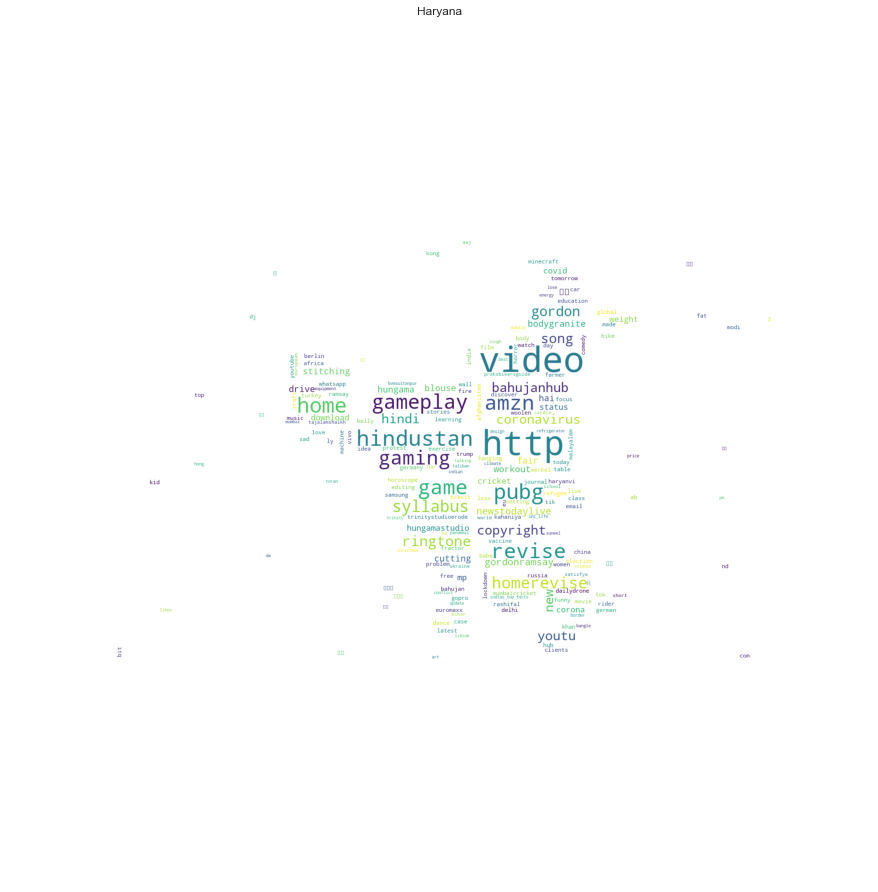

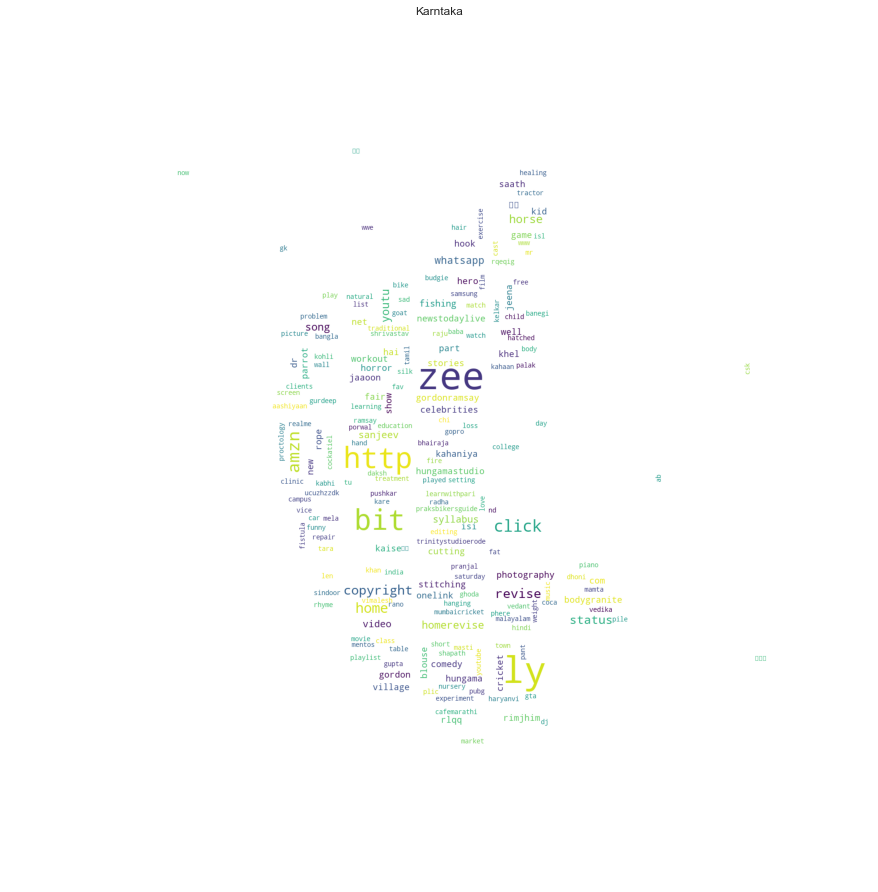

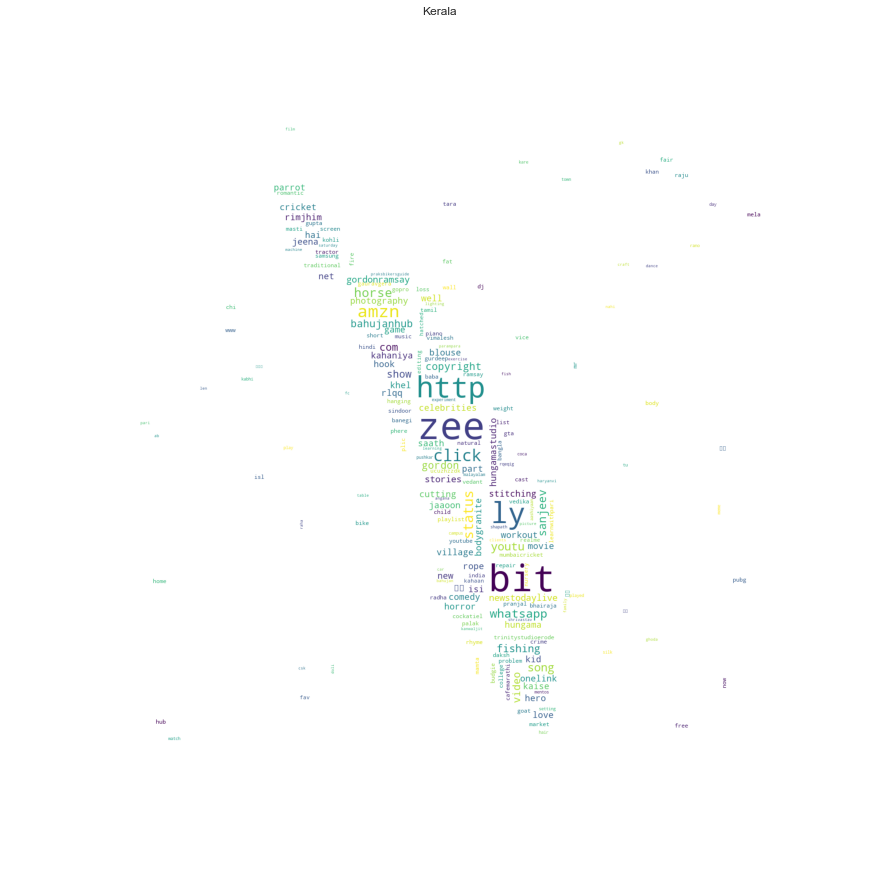

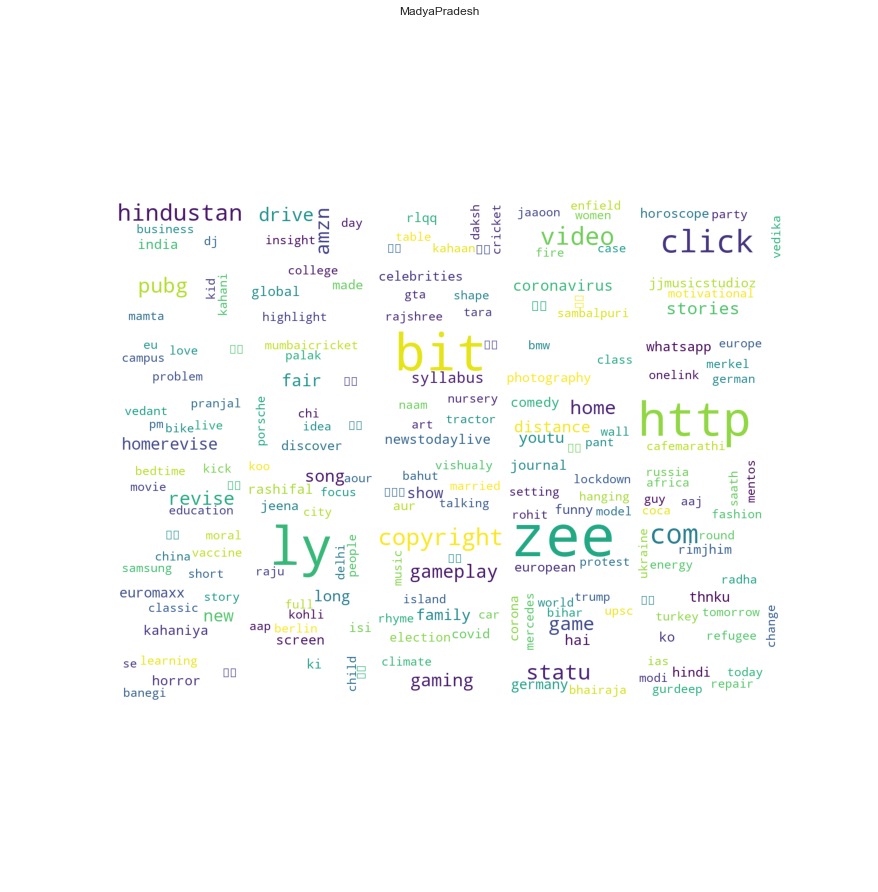

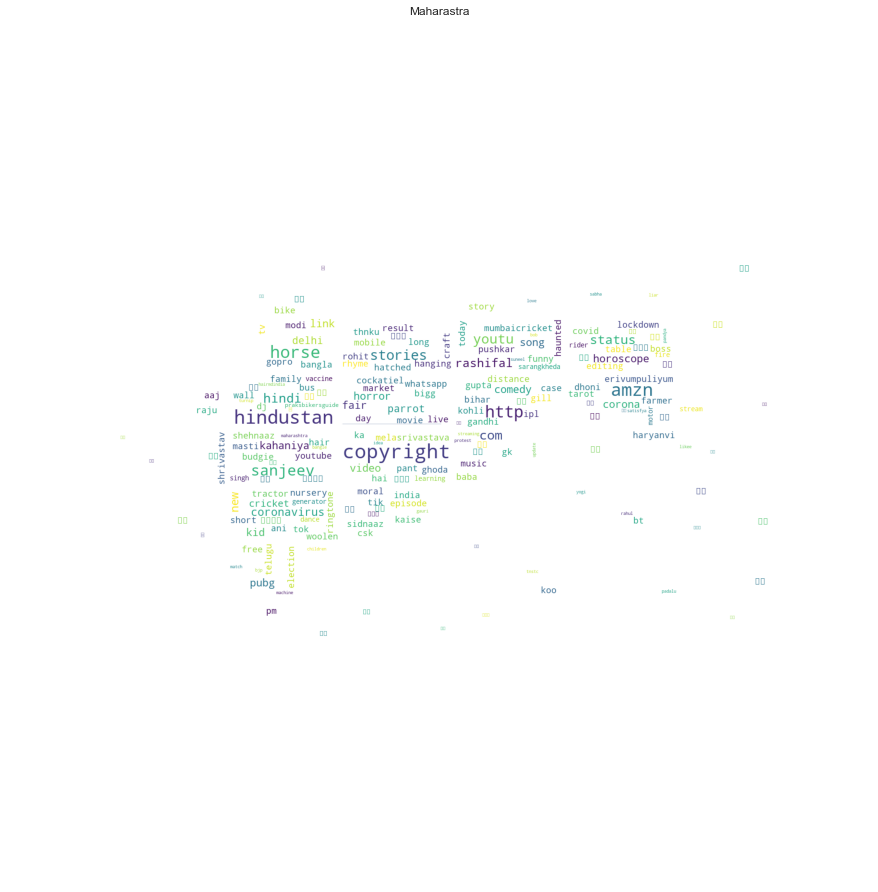

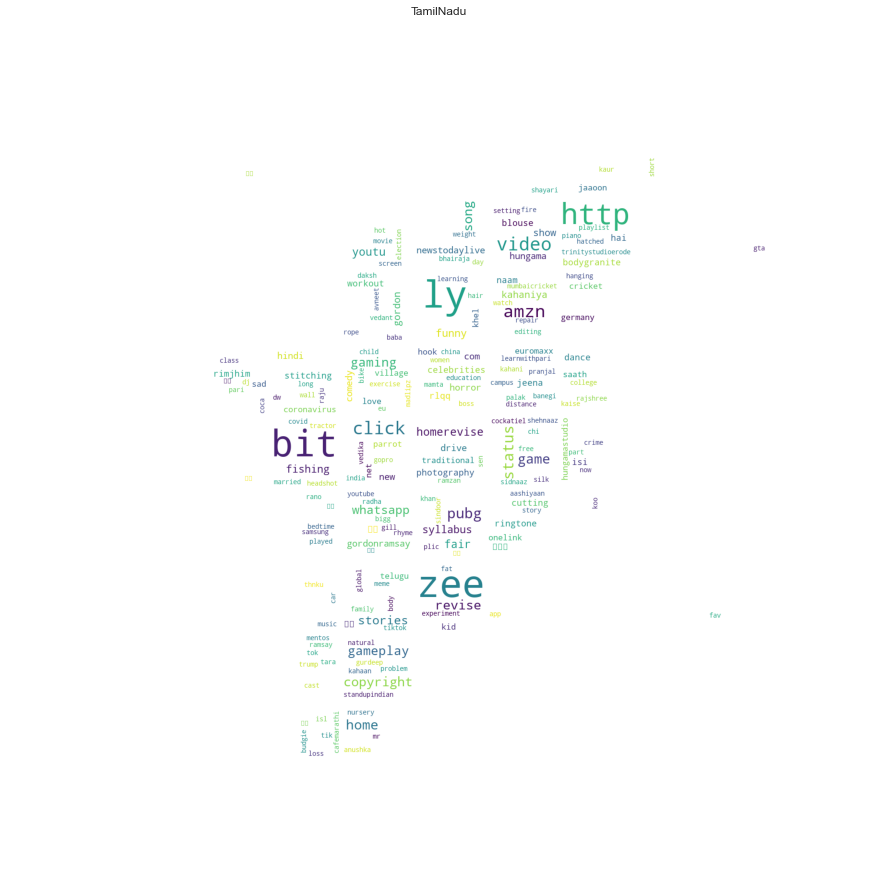

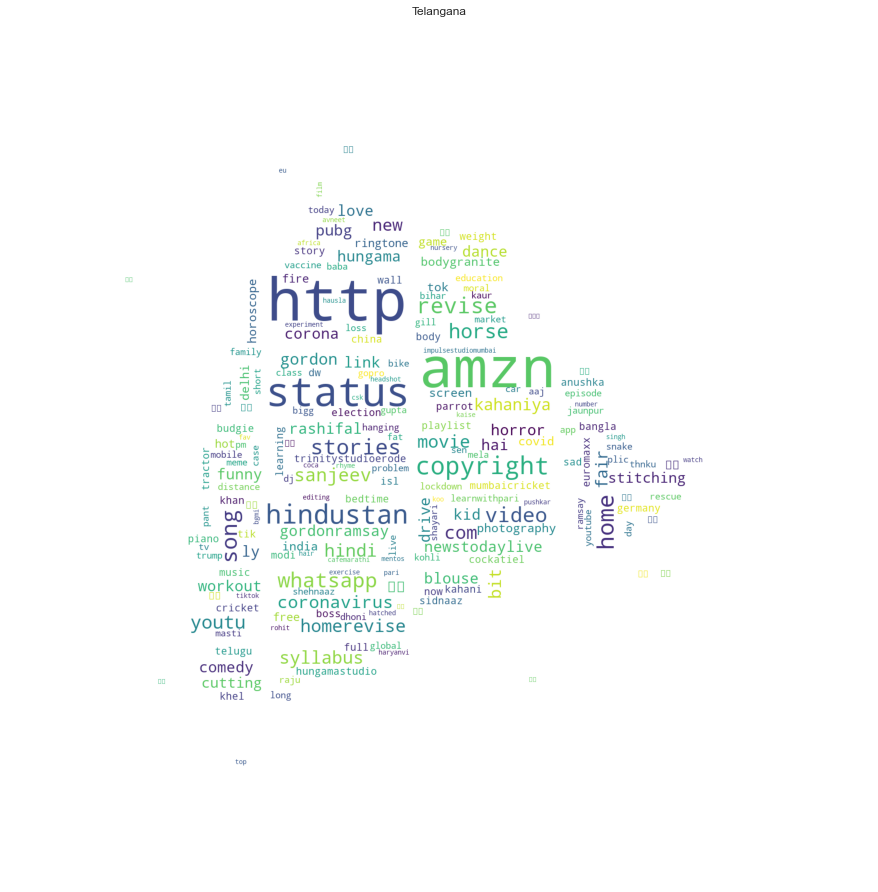

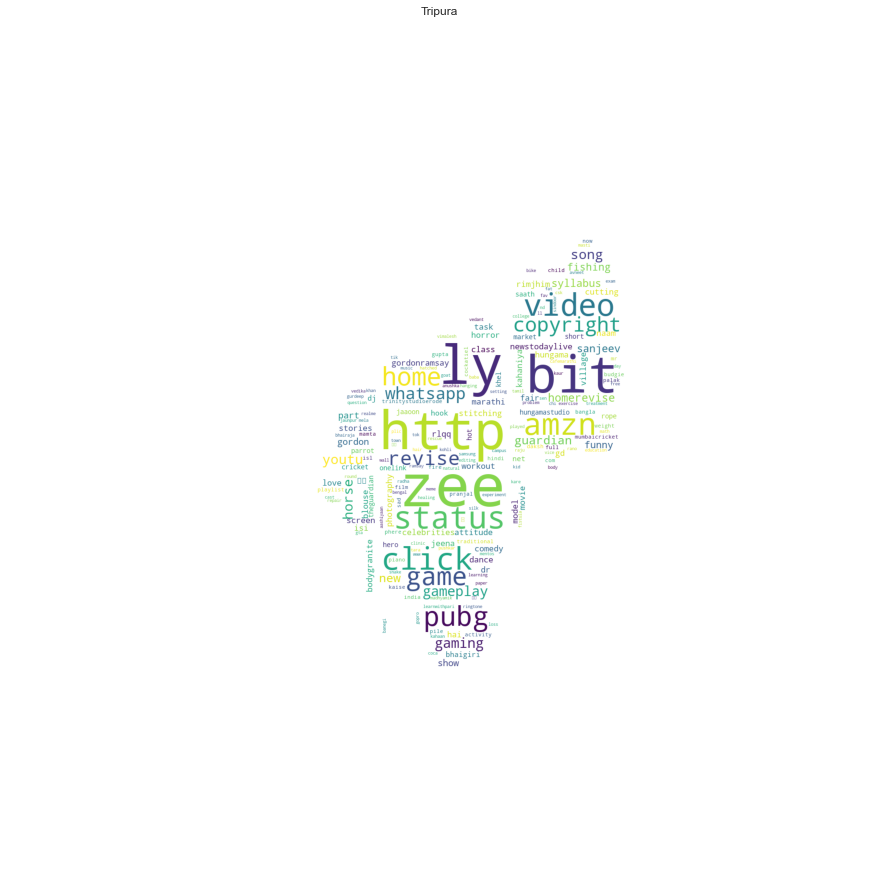

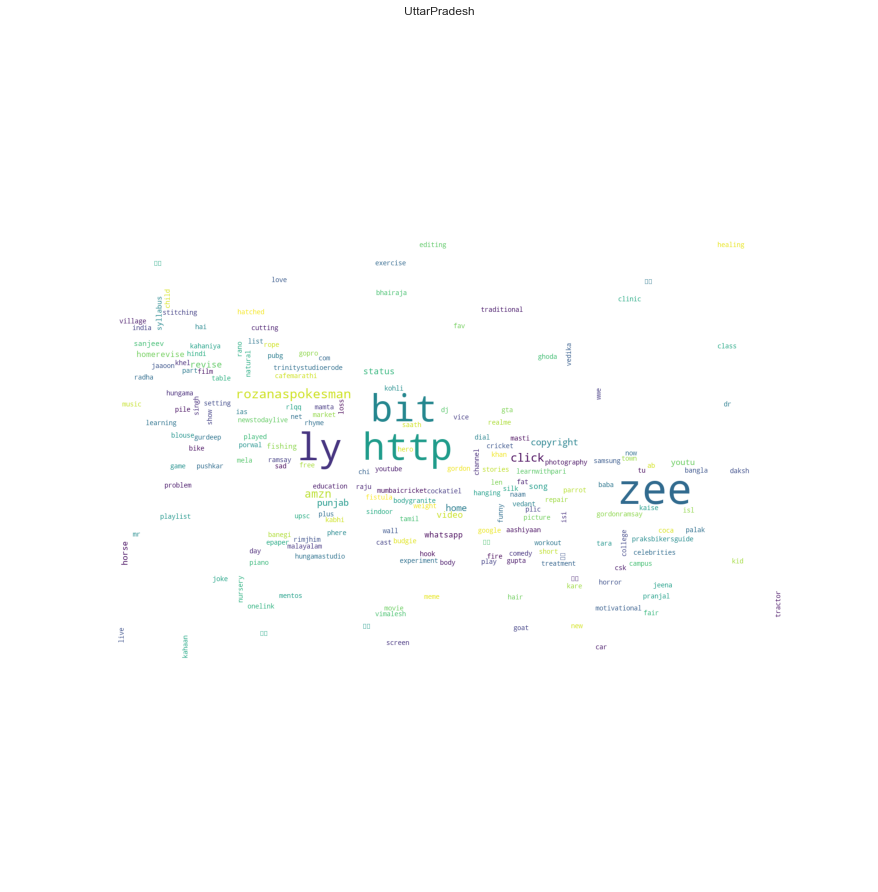

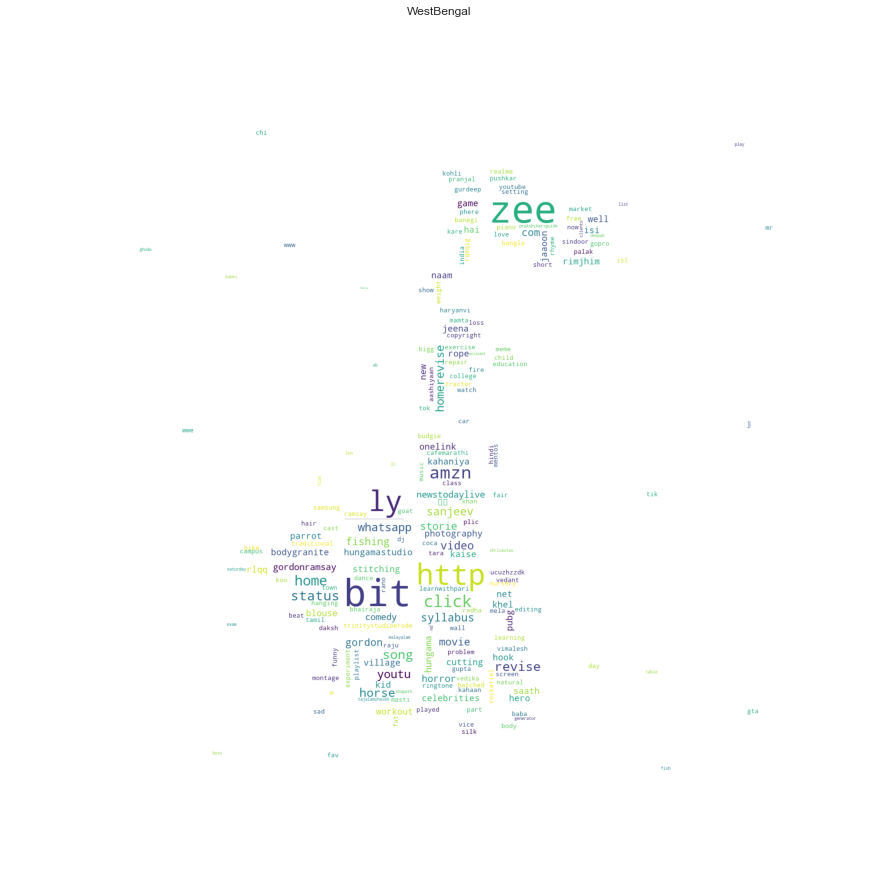

In [74]:
# plot the WordCloud image    
for state_wordcloud, state in zip(states_wordcloud, states):
    plt.figure(figsize = (12,12), facecolor = None)
    plt.imshow(state_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(state)
    plt.show()
# plt.imshow(states_wordcloud[1, interpolation='bilinear')

In [72]:
# tfidf(filename,image)

In [73]:
# Just try two things to improve ths try to get high res images of states and have increase the wordcounts

In [ ]:
#No we need o have different paths for different images of the stated and then we can call them for a specific action

In [ ]:
# The bottom part is not needed anymore

## Wordcloud based on top liked and disliked count for youtTube india data

In [ ]:

# word count
i = 0
for i in range(2):
    if i == 0:
        df_eda.sort_values(['likeCount'], ascending=False,axis=0,inplace=True)
    else:
        df_eda.sort_values(['dislikeCount'], ascending=False,axis=0,inplace=True)
    
    comment_words = ''
    stopwords = set(STOPWORDS)
    
    # iterate through the csv file
    for val in df.description.iloc[0:10000]:
         
        # typecaste each val to string
        val = str(val)
     
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
         
        comment_words += " ".join(tokens)+" "
     
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
     
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title('Top Liked/Disliked Description')
         
plt.show()